In [2]:
%matplotlib inline

import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from IPython import display
plt.ion()

# if gpu is to be used
device = torch.device("cuda")

In [45]:
env = NormalizedEnv(gym.make('Pendulum-v0'))

***

In [44]:
class NormalizedEnv(gym.ActionWrapper):
    """ Wrap action """

    def action(self, action):
        act_k = (self.action_space.high - self.action_space.low)/ 2.
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k * action + act_b

    def reverse_action(self, action):
        act_k_inv = 2./(self.action_space.high - self.action_space.low)
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k_inv * (action - act_b)

In [36]:
def plot_durations(episode_durations):
    fig, axs = plt.subplots(2, figsize=(10,10))
    
    durations_t, durations = list(map(list, zip(*episode_durations)))
    durations = torch.tensor(durations, dtype=torch.float)
    
    fig.suptitle('Training')
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Reward')
    
    axs[0].plot(durations_t, durations.numpy())
        
    plt.pause(0.001)  # pause a bit so that plots are updated
    display.clear_output(wait=True)

In [5]:
# [reference] https://github.com/matthiasplappert/keras-rl/blob/master/rl/random.py

class RandomProcess(object):
    def reset_states(self):
        pass

class AnnealedGaussianProcess(RandomProcess):
    def __init__(self, mu, sigma, sigma_min, n_steps_annealing):
        self.mu = mu
        self.sigma = sigma
        self.n_steps = 0

        if sigma_min is not None:
            self.m = -float(sigma - sigma_min) / float(n_steps_annealing)
            self.c = sigma
            self.sigma_min = sigma_min
        else:
            self.m = 0.
            self.c = sigma
            self.sigma_min = sigma

    @property
    def current_sigma(self):
        sigma = max(self.sigma_min, self.m * float(self.n_steps) + self.c)
        return sigma


# Based on http://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab
class OrnsteinUhlenbeckProcess(AnnealedGaussianProcess):
    def __init__(self, theta, mu=0., sigma=1., dt=1e-2, x0=None, size=1, sigma_min=None, n_steps_annealing=1000):
        super(OrnsteinUhlenbeckProcess, self).__init__(mu=mu, sigma=sigma, sigma_min=sigma_min, n_steps_annealing=n_steps_annealing)
        self.theta = theta
        self.mu = mu
        self.dt = dt
        self.x0 = x0
        self.size = size
        self.reset_states()

    def sample(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.current_sigma * np.sqrt(self.dt) * np.random.normal(size=self.size)
        self.x_prev = x
        self.n_steps += 1
        return x

    def reset_states(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros(self.size)

In [6]:
def soft_update(target, source, tau):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(
            target_param.data * (1.0 - tau) + param.data * tau
        )

def hard_update(target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)

In [7]:
# (state, action) -> (next_state, reward, done)
transition = namedtuple('transition', ('state', 'action', 'next_state', 'reward', 'done'))

# replay memory D with capacity N
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    # implemented as a cyclical queue
    def store(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        
        self.memory[self.position] = transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

***

In [16]:
def fanin_init(size, fanin=None):
    fanin = fanin or size[0]
    v = 1. / np.sqrt(fanin)
    return torch.Tensor(size).uniform_(-v, v)

class Actor(nn.Module):
    def __init__(self, nb_states, nb_actions):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(nb_states, 400)
        self.fc2 = nn.Linear(400, 300)
        self.head = nn.Linear(300, nb_actions)
        
        self.tanh = nn.Tanh()
        self.init_weights(3e-3)
    
    def init_weights(self, init_w):
        self.fc1.weight.data = fanin_init(self.fc1.weight.data.size())
        self.fc2.weight.data = fanin_init(self.fc2.weight.data.size())
        self.head.weight.data.uniform_(-init_w, init_w)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.tanh(self.head(x))

class Critic(nn.Module):
    def __init__(self, nb_states, nb_actions):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(nb_states, 400)
        self.fc2 = nn.Linear(400 + nb_actions, 300)
        self.head = nn.Linear(300, 1)

        self.init_weights(3e-3)
      
    def init_weights(self, init_w):
        self.fc1.weight.data = fanin_init(self.fc1.weight.data.size())
        self.fc2.weight.data = fanin_init(self.fc2.weight.data.size())
        self.head.weight.data.uniform_(-init_w, init_w)
    
    def forward(self, xs):
        x, a = xs
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(torch.cat([x,a],1)))
        return self.head(x)

In [47]:
BATCH_SIZE = 64
GAMMA = 0.99

class DDPG(nn.Module):
    def __init__(self, nb_states, nb_actions):
        super(DDPG, self).__init__()
        self.nb_states = nb_states
        self.nb_actions= nb_actions
        
        self.actor = Actor(self.nb_states, self.nb_actions)
        self.actor_target = Actor(self.nb_states, self.nb_actions)
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=0.0001)

        self.critic = Critic(self.nb_states, self.nb_actions)
        self.critic_target = Critic(self.nb_states, self.nb_actions)
        self.critic_optimizer  = optim.Adam(self.critic.parameters(), lr=0.0001)

        hard_update(self.actor_target, self.actor)
        hard_update(self.critic_target, self.critic)
        
        #Create replay buffer
        self.memory = ReplayMemory(6000000)
        self.random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=0.15, mu=0.0, sigma=0.2)

        # Hyper-parameters
        self.tau = 0.001
        self.depsilon = 1.0 / 50000

        # 
        self.epsilon = 1.0
        self.s_t = None # Most recent state
        self.a_t = None # Most recent action
        self.is_training = True

    def update_policy(self):
        if len(self.memory) < BATCH_SIZE:
            return
        
        # in the form (state, action) -> (next_state, reward, done)
        transitions = self.memory.sample(BATCH_SIZE)
        batch = transition(*zip(*transitions))
        
        state_batch = torch.cat(batch.state)
        next_state_batch = torch.cat(batch.next_state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        done_mask = np.array(batch.done)
        not_done_mask = torch.from_numpy(1 - done_mask).float().to(device)

        # Prepare for the target q batch
        next_q_values = self.critic_target([
            next_state_batch,
            self.actor_target(next_state_batch),
        ]).detach().squeeze(1)

        target_q_batch = reward_batch + GAMMA * not_done_mask * next_q_values
        
        # Critic update
        self.critic_optimizer.zero_grad()

        q_batch = self.critic([ state_batch, action_batch ])
        
        value_loss = F.mse_loss(q_batch, target_q_batch.unsqueeze(1))
        value_loss.backward()
        self.critic_optimizer.step()

        # Actor update
        self.actor_optimizer.zero_grad()

        policy_loss = -self.critic([
            state_batch,
            self.actor(state_batch)
        ])

        policy_loss = policy_loss.mean()
        policy_loss.backward()
        self.actor_optimizer.step()

        # Target update
        soft_update(self.actor_target, self.actor, self.tau)
        soft_update(self.critic_target, self.critic, self.tau)

    def eval(self):
        self.actor.eval()
        self.actor_target.eval()
        self.critic.eval()
        self.critic_target.eval()

    def observe(self, r_t, s_t1, done):
        if self.is_training:
            self.memory.store(self.s_t, self.a_t, s_t1, r_t, done)
            self.s_t = s_t1

    def random_action(self):
        action = torch.tensor([np.random.uniform(-1.,1.,self.nb_actions)], device=device, dtype=torch.float)
        self.a_t = action
        
        return action

    def select_action(self, s_t, decay_epsilon=True):
        with torch.no_grad():
            action = self.actor(s_t).squeeze(0)
            action += torch.from_numpy(self.is_training * max(self.epsilon, 0) * self.random_process.sample()).to(device).float()
            action = torch.clamp(action, -1., 1.)

            action = action.unsqueeze(0)
            
            if decay_epsilon:
                self.epsilon -= self.depsilon
            
            self.a_t = action
            return action

    def reset(self, obs):
        self.s_t = obs
        self.random_process.reset_states()

In [48]:
def train_model():
    n_observations = env.observation_space.shape[0]
    n_actions = env.action_space.shape[0]
    
    agent = DDPG(n_observations, n_actions).to(device)
    
    max_episode_length = 500
    
    agent.is_training = True
    episode_reward = 0.
    observation = None
    
    warmup = 10
    num_episodes = 500 # M
    episode_durations = []

    steps = 0

    for i_episode in range(num_episodes):
        observation = env.reset()
        state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
        agent.reset(state)
        
        overall_reward = 0
        episode_steps = 0
        done = False
        while not done:
            # agent pick action ...
            if i_episode <= warmup:
                action = agent.random_action()
            else:
                action = agent.select_action(state)

            # env response with next_observation, reward, terminate_info
            observation, reward, done, info = env.step(action.detach().cpu().squeeze(0).numpy())
            steps += 1
            
            if max_episode_length and episode_steps >= max_episode_length -1:
                done = True
                
            extrinsic_reward = torch.tensor([reward], device=device)
            
            overall_reward += reward
            
            next_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)

            # agent observe and update policy
            agent.observe(extrinsic_reward, next_state, done)

            episode_steps += 1            
            state = next_state
            
            if i_episode > warmup:
                agent.update_policy()

        episode_durations.append((steps, overall_reward))
        plot_durations(episode_durations)

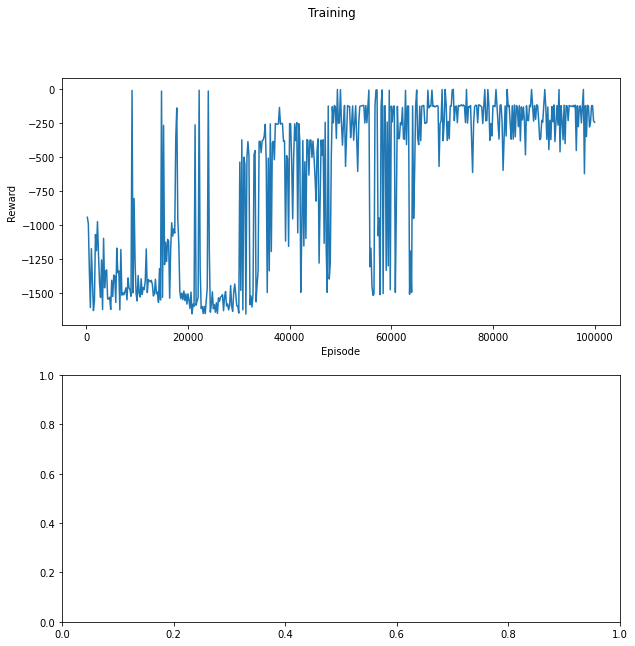

In [49]:
train_model()